# **Analyse de données des ventes électronique**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import chardet

In [2]:
def detect_encoding(file_path):
    """
    Détecte l'encodage du fichier.
    """
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    return chardet.detect(raw_data)['encoding']

def load_and_clean_data(file_path):
    """
    Charge et nettoie les données à partir d'un fichier CSV.
    """
    encoding = detect_encoding(file_path)
    df = pd.read_csv(file_path, encoding=encoding)
    
    # Convertir les colonnes de dates en datetime
    date_columns = ['Order Date', 'Delivery Date', 'Birthday', 'Open Date', 'Date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Nettoyer les colonnes monétaires
    money_columns = ['Unit Cost USD', 'Unit Price USD']
    for col in money_columns:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def load_all_data():
    """
    Charge tous les fichiers de données et retourne un dictionnaire de dataframes.
    """
    files = ['Sales.csv', 'Products.csv', 'Customers.csv', 'Stores.csv', 'Exchange_Rates.csv']
    data = {}
    
    for file in files:
        name = file.split('.')[0].lower()
        data[name] = load_and_clean_data(f'Data/{file}')
    
    return data

def merge_sales_data(data):
    """
    Fusionne les données de ventes avec les informations sur les produits, clients et magasins.
    """
    sales = data['sales']
    sales = sales.merge(data['products'], on='ProductKey', how='left')
    sales = sales.merge(data['customers'], on='CustomerKey', how='left')
    sales = sales.merge(data['stores'], on='StoreKey', how='left')
    
    # Ajouter le taux de change
    sales = sales.merge(data['exchange_rates'], left_on=['Order Date', 'Currency Code'], 
                        right_on=['Date', 'Currency'], how='left')
    
    # Calculer le montant en USD
    sales['Amount USD'] = sales['Quantity'] * sales['Unit Price USD']
    sales['Amount Local'] = sales['Amount USD'] * sales['Exchange']
    
    return sales

def calculate_delivery_time(sales):
    """
    Calcule le temps de livraison en jours.
    """
    sales['Delivery Time'] = (sales['Delivery Date'] - sales['Order Date']).dt.days
    return sales

In [3]:
# Exemple d'utilisation
if __name__ == "__main__":
    data = load_all_data()
    merged_sales = merge_sales_data(data)
    merged_sales = calculate_delivery_time(merged_sales)
    print(merged_sales.head())
    print(merged_sales.columns)

   Order Number  Line Item Order Date Delivery Date  CustomerKey  StoreKey  \
0        366000          1 2016-01-01           NaT       265598        10   
1        366001          1 2016-01-01    2016-01-13      1269051         0   
2        366001          2 2016-01-01    2016-01-13      1269051         0   
3        366002          1 2016-01-01    2016-01-12       266019         0   
4        366002          2 2016-01-01    2016-01-12       266019         0   

   ProductKey  Quantity Currency Code                            Product Name  \
0        1304         1           CAD         Contoso Lens Adapter M450 White   
1        1048         2           USD         A. Datum SLR Camera X136 Silver   
2        2007         1           USD  Fabrikam Microwave 1.5CuFt X1100 Black   
3        1106         7           CAD          Contoso SLR Camera M146 Orange   
4         373         1           CAD   Adventure Works Laptop8.9 E0890 White   

   ... Country_y  State_y  Square Meters  Op

In [19]:
# Analyse des produits vendus et de la répartition géographique des clients
#from utils import load_all_data, merge_sales_data
# Chargement des données
data = load_all_data()
merged_sales = merge_sales_data(data)
# Résolution du problème des colonnes dupliquées
merged_sales = merged_sales.rename(columns={'Country_x': 'Country'})

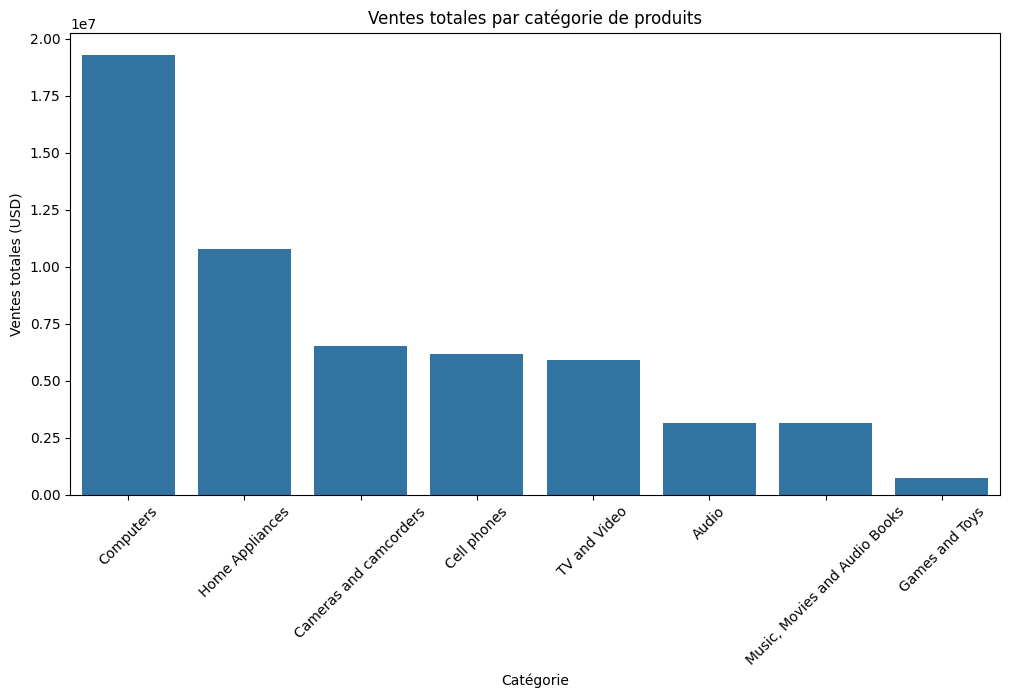

In [20]:
# 1. Analyse des types de produits vendus

## 1.1 Distribution des ventes par catégorie de produits
category_sales = merged_sales.groupby('Category')['Amount USD'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_sales.index, y=category_sales.values)
plt.title('Ventes totales par catégorie de produits')
plt.xlabel('Catégorie')
plt.ylabel('Ventes totales (USD)')
plt.xticks(rotation=45)
plt.show()

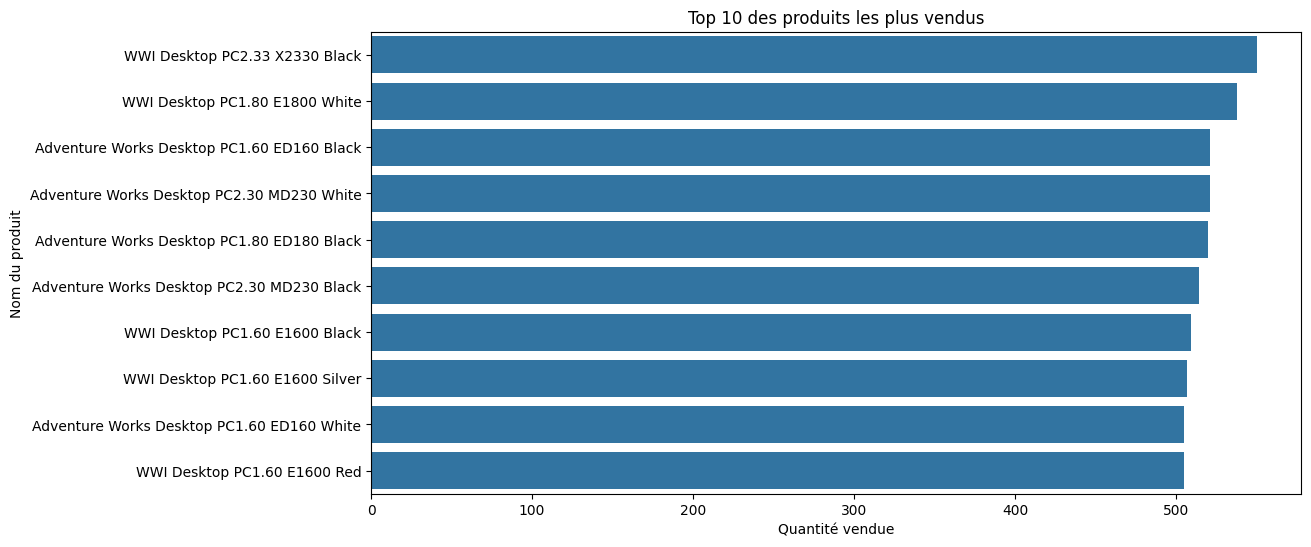

In [21]:
## 1.2 Top 10 des produits les plus vendus
top_products = merged_sales.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 des produits les plus vendus')
plt.xlabel('Quantité vendue')
plt.ylabel('Nom du produit')
plt.show()

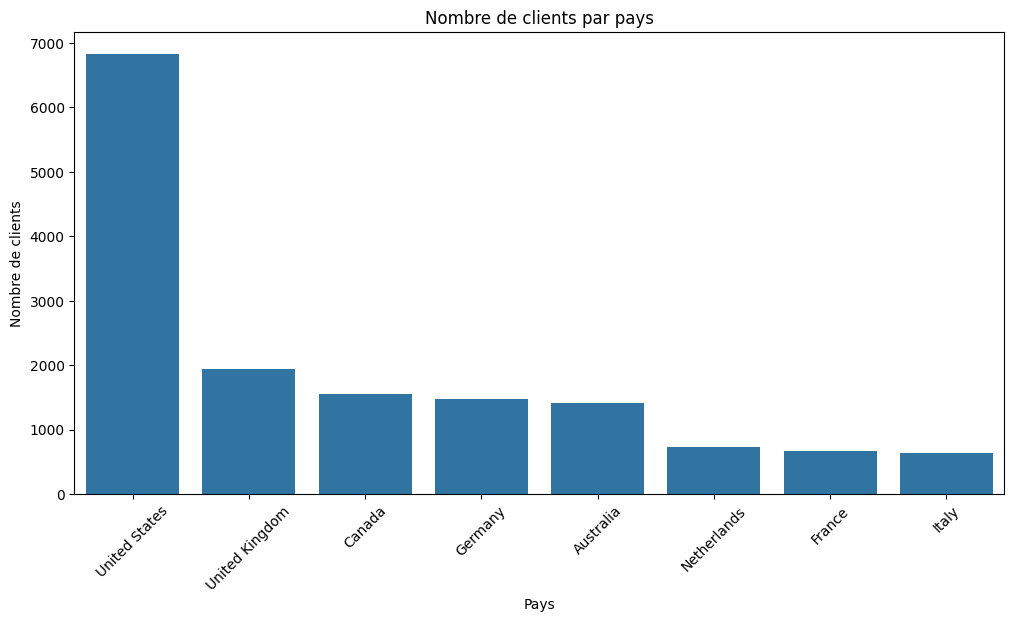

In [22]:
# 2. Répartition géographique des clients

## 2.1 Nombre de clients par pays
customers_by_country = data['customers']['Country'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=customers_by_country.index, y=customers_by_country.values)
plt.title('Nombre de clients par pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.show()

In [29]:
## 2.2 Carte choroplèthe des ventes par pays
sales_by_country = merged_sales.groupby('Country')['Amount USD'].sum().reset_index()

fig = px.choropleth(sales_by_country, 
                    locations='Country', 
                    locationmode='country names',
                    color='Amount USD', 
                    hover_name='Country', 
                    color_continuous_scale='Viridis')

fig.update_layout(title='Répartition des ventes par pays')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': '<b>%{hovertext}</b><br><br>Country=%{location}<br>Amount USD=%{z}<extra></extra>',
              'hovertext': array(['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands',
                                  'United Kingdom', 'United States'], dtype=object),
              'locationmode': 'country names',
              'locations': array(['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands',
                                  'United Kingdom', 'United States'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([ 2708137.61,  4724334.63,  1515338.22,  5414149.8 ,  2475645.77,
                           1962154.27,  7084088.12, 29871631.17])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Amount USD'}},
                             'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                            '#482878'], [0.2222222222222222,
                                            '#3e4989'], [0.3333333333333333,
                                            '#31688e'], [0.4444444444444444,
                                            '#26828e'], [0.5555555555555556,
                                            '#1f9e89'], [0.6666666666666666,
                                            '#35b779'], [0.7777777777777778,
                                            '#6ece58'], [0.8888888888888888,
                                            '#b5de2b'], [1.0, '#fde725']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Répartition des ventes par pays'}}
})

In [30]:
# Utilisation de .write_html() au lieu de .show()
fig.write_html("sales_by_country_map.html")
print("La carte des ventes par pays a été sauvegardée dans 'sales_by_country_map.html'")

# Affichage des données brutes pour vérification
print(sales_by_country.sort_values('Amount USD', ascending=False).head())

# 3. Analyse croisée : Catégories de produits les plus populaires par pays
top_categories_by_country = merged_sales.groupby(['Country', 'Category'])['Amount USD'].sum().reset_index()
top_categories_by_country = top_categories_by_country.sort_values(['Country', 'Amount USD'], ascending=[True, False])
top_categories_by_country = top_categories_by_country.groupby('Country').first().reset_index()

La carte des ventes par pays a été sauvegardée dans 'sales_by_country_map.html'
          Country   Amount USD
7   United States  29871631.17
6  United Kingdom   7084088.12
3         Germany   5414149.80
1          Canada   4724334.63
0       Australia   2708137.61


In [31]:
fig = px.choropleth(top_categories_by_country, 
                    locations='Country', 
                    locationmode='country names',
                    color='Category', 
                    hover_name='Country', 
                    hover_data=['Amount USD'])

fig.update_layout(title='Catégorie de produit la plus vendue par pays')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'colorscale': [[0.0, '#636efa'], [1.0, '#636efa']],
              'customdata': array([[  857960.8 ],
                                   [ 1653008.1 ],
                                   [  559149.03],
                                   [ 1930179.9 ],
                                   [  847064.68],
                                   [  729804.59],
                                   [ 2404526.35],
                                   [10319902.01]]),
              'geo': 'geo',
              'hovertemplate': ('<b>%{hovertext}</b><br><br>Cat' ... '{customdata[0]}<extra></extra>'),
              'hovertext': array(['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands',
                                  'United Kingdom', 'United States'], dtype=object),
              'locationmode': 'country names',
              'locations': array(['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands',
                                  'United Kingdom', 'United States'], dtype=object),
              'name': 'Computers',
              'showlegend': True,
              'showscale': False,
              'type': 'choropleth',
              'z': [1, 1, 1, 1, 1, 1, 1, 1]}],
    'layout': {'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}},
               'legend': {'title': {'text': 'Category'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Catégorie de produit la plus vendue par pays'}}
})

In [32]:
# Utilisation de .write_html() au lieu de .show()
fig.write_html("top_categories_by_country_map.html")
print("La carte des catégories les plus vendues par pays a été sauvegardée dans 'top_categories_by_country_map.html'")

La carte des catégories les plus vendues par pays a été sauvegardée dans 'top_categories_by_country_map.html'


In [33]:
# Affichage des données brutes pour vérification
print(top_categories_by_country.head())

     Country   Category  Amount USD
0  Australia  Computers   857960.80
1     Canada  Computers  1653008.10
2     France  Computers   559149.03
3    Germany  Computers  1930179.90
4      Italy  Computers   847064.68


In [35]:
# Conclusions et insights
#print("Insights sur les produits vendus et la répartition géographique des clients :")
#print("1. Les catégories de produits les plus vendues sont...")
#print("2. Les pays avec le plus grand nombre de clients sont...")
#print("3. Les pays générant le plus de ventes sont...")
#print("4. On observe une préférence pour la catégorie ... dans la plupart des pays.")

In [36]:
# Analyse des tendances temporelles et saisonnières des ventes

# Assurons-nous que la colonne 'Order Date' est bien en format datetime
merged_sales['Order Date'] = pd.to_datetime(merged_sales['Order Date'])

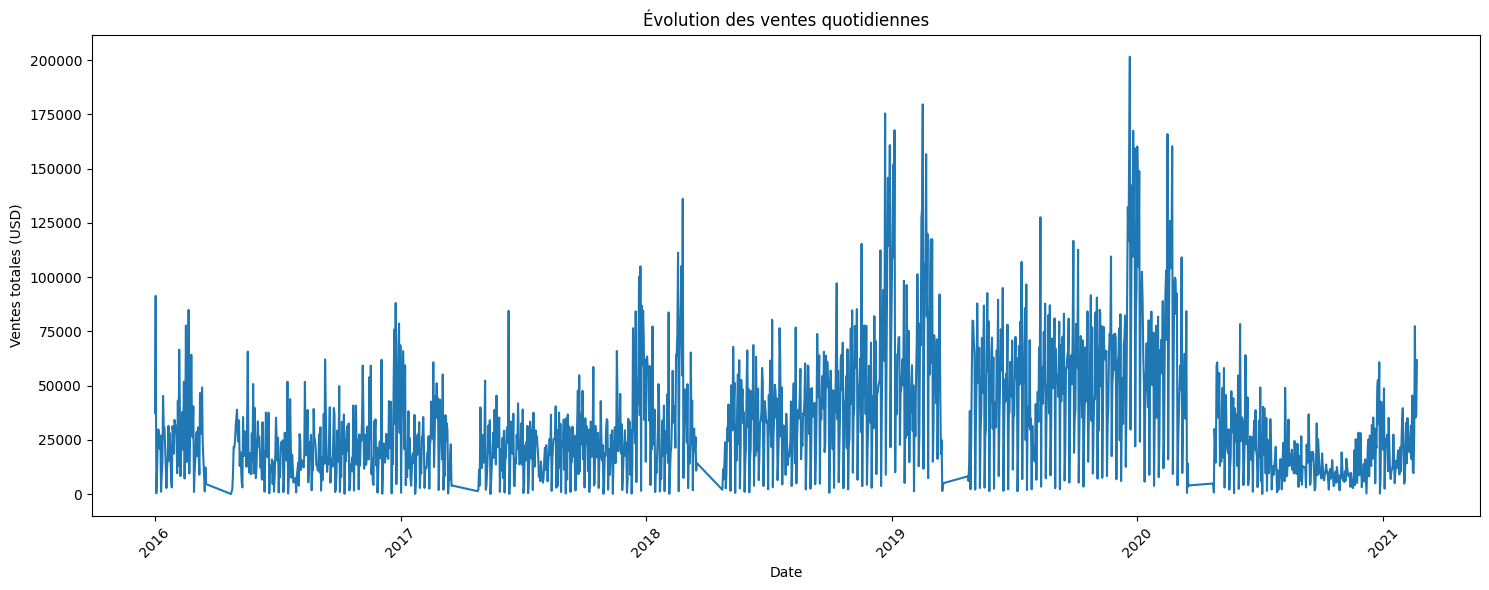

In [37]:
# 1. Tendance générale des ventes au fil du temps

# Agrégation des ventes par jour
daily_sales = merged_sales.groupby('Order Date')['Amount USD'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Order Date'], daily_sales['Amount USD'])
plt.title('Évolution des ventes quotidiennes')
plt.xlabel('Date')
plt.ylabel('Ventes totales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()